In [1]:
from keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D
from keras.models import Sequential
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random

import warnings
warnings.filterwarnings('ignore')


Using TensorFlow backend.


In [2]:
# Read Data
data = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')
data.head(5)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [3]:
data.shape

(8732, 8)

In [4]:
#Get data over 3 seconds long 
valid_data = data[['slice_file_name' , 'fold', 'classID', 'class']] [data ['end'] - data['start'] >= 3]
valid_data.shape


(7468, 4)

In [5]:
#Example of Siren Spectogram 
y, sr = librosa.load('UrbanSound8K/audio/fold6/135160-8-0-0.wav', duration = 2.97)
ps = librosa.feature.melspectrogram(y = y, sr = sr)
ps.shape

(128, 128)

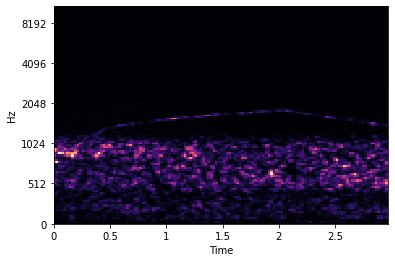

In [6]:
librosa.display.specshow(ps, y_axis = 'mel', x_axis = 'time')

In [7]:
#Play audio 
from IPython.display import Audio, display, clear_output

display(Audio(y, rate=sr, autoplay=False))

In [8]:
valid_data['path'] = 'fold'+ valid_data['fold'].astype('str')+'/'+valid_data['slice_file_name'].astype('str')

In [9]:
D = [] # Dataset

for row in valid_data.itertuples():
    y, sr = librosa.load('UrbanSound8K/audio/' + row.path, duration=2.97)  
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    if ps.shape != (128, 128): continue
    D.append( (ps, row.classID) )
    

In [43]:
dataset = D
random.shuffle(dataset)

train = dataset[:7000]
test = dataset[7000:]

X_train, Y_train = zip(*train)
X_test, Y_test = zip(*test)

# Reshape for CNN input
X_train = np.array([x.reshape( (128, 128, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, 128, 1) ) for x in X_test])

# One-Hot encoding for classes
Y_train = np.array(keras.utils.to_categorical(Y_train, 10))
Y_test = np.array(keras.utils.to_categorical(Y_test, 10))

In [44]:
model = Sequential()
input_shape=(128, 128, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(10))
model.add(Activation('softmax'))

In [45]:
model.compile(
    optimizer="Adam",
    loss="categorical_crossentropy",
    metrics=['accuracy'])

model.fit(
    x=X_train, 
    y=Y_train,
    epochs=12,
    batch_size=128,
    validation_data= (X_test, Y_test))

score = model.evaluate(
    x=X_test,
    y=Y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 7000 samples, validate on 467 samples
Epoch 1/12
7000/7000 [==============================] - 58s 8ms/step - loss: 2.7119 - accuracy: 0.2001 - val_loss: 2.0971 - val_accuracy: 0.3169
Epoch 2/12
7000/7000 [==============================] - 59s 8ms/step - loss: 2.0765 - accuracy: 0.2764 - val_loss: 1.8496 - val_accuracy: 0.3940
Epoch 3/12
7000/7000 [==============================] - 57s 8ms/step - loss: 1.8316 - accuracy: 0.3406 - val_loss: 1.6417 - val_accuracy: 0.4497
Epoch 4/12
7000/7000 [==============================] - 545s 78ms/step - loss: 1.6863 - accuracy: 0.3953 - val_loss: 1.5122 - val_accuracy: 0.4861
Epoch 5/12
7000/7000 [==============================] - 84s 12ms/step - loss: 1.5370 - accuracy: 0.4493 - val_loss: 1.3809 - val_accuracy: 0.5439
Epoch 6/12
7000/7000 [==============================] - 103s 15ms/step - loss: 1.4662 - accuracy: 0.4813 - val_loss: 1.4054 - val_accuracy: 0.5075
Epoch 7/12
7000/7000 [==============================] - 65s 9ms/step - loss: 1